# Traffic GAN

## import libraries

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os

from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

In [14]:
# input traffic dimensions
traf_rows =100#100
traf_cols = 2
channels = 1
traf_shape = (traf_rows, traf_cols, channels)

mid_layer = 32#32

# Size of the noise vector, used as input to the Generator
z_dim = 10

## CSV Reader

In [15]:
os.chdir('/Users/a-sawabe/Project/1.Programming/gan/traffic-gan/dataset_vsize')

df = pd.DataFrame(columns = [])
for i in glob.glob("*sensor_b*"):#("*.csv"):
    tmp = pd.read_csv(i, header=None)
    _tmp = tmp.loc[0:traf_rows-1,:]
    df = pd.concat([df, _tmp])

df = df.values.reshape(-1, traf_rows, traf_cols, 1)

# TODO: Feature scaling
df[:,:,0] = df[:,:,0]/1500*2-1
df[:,:,1] = df[:,:,1]/105*2-1

print(df.shape)

(10, 100, 2, 1)


### Generator

In [16]:
def build_generator(traf_shape, z_dim):

    model = Sequential()

    # Fully connected layer
    model.add(Dense(mid_layer, input_dim=z_dim))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with tanh activation
    model.add(Dense(traf_rows*traf_cols*channels, activation='tanh'))

    # Reshape the Generator output to image dimensions
    model.add(Reshape(traf_shape))

    return model

## Discriminator

In [17]:
def build_discriminator(traf_shape):

    model = Sequential()

    # Flatten the input image
    model.add(Flatten(input_shape=traf_shape))

    # Fully connected layer
    model.add(Dense(mid_layer))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))

    return model

## Build the Model

In [18]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

In [19]:
# Build and compile the Discriminator
discriminator = build_discriminator(traf_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

#discriminator_traf.summary()

# Build the Generator
generator = build_generator(traf_shape, z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

## Training

In [20]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):
    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images
        idx = np.random.randint(0, df.shape[0], batch_size)
        trafs = df[idx]
        
        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_trafs = generator.predict(z)

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(trafs, real)
        d_loss_fake = discriminator.train_on_batch(gen_trafs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_trafs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # TODO: output
            _a = gen_trafs[0]
            _a[:,0,0] = (_a[:,0,0] + 1) * 1500 / 2
            _a[:,1,0] = (_a[:,1,0] + 1) * 105 / 2
            save_file = '../logs/' + str(iteration) + '.csv'
            np.savetxt(save_file,_a[:, :, 0],delimiter=',')

## Train the GAN and Inspect Output

In [21]:
# Set hyperparameters
iterations = 20000
batch_size = 128#128
sample_interval = 100

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

100 [D loss: 0.136520, acc.: 100.00%] [G loss: 1.645647]
200 [D loss: 0.101165, acc.: 100.00%] [G loss: 1.931304]
300 [D loss: 0.076965, acc.: 100.00%] [G loss: 2.214309]
400 [D loss: 0.054914, acc.: 100.00%] [G loss: 2.630000]
500 [D loss: 0.070065, acc.: 100.00%] [G loss: 2.789513]
600 [D loss: 0.142973, acc.: 96.88%] [G loss: 3.046486]
700 [D loss: 0.154822, acc.: 98.83%] [G loss: 2.712678]
800 [D loss: 0.252082, acc.: 99.61%] [G loss: 1.773967]
900 [D loss: 0.367670, acc.: 91.02%] [G loss: 1.714972]
1000 [D loss: 0.535709, acc.: 80.86%] [G loss: 1.242587]
1100 [D loss: 0.702045, acc.: 60.16%] [G loss: 0.766259]
1200 [D loss: 0.894480, acc.: 6.64%] [G loss: 0.617746]
1300 [D loss: 0.769866, acc.: 23.83%] [G loss: 0.697330]
1400 [D loss: 0.463838, acc.: 94.53%] [G loss: 1.146544]
1500 [D loss: 0.800447, acc.: 8.98%] [G loss: 0.681448]
1600 [D loss: 0.532607, acc.: 95.31%] [G loss: 1.023132]
1700 [D loss: 0.736469, acc.: 22.27%] [G loss: 0.757436]
1800 [D loss: 0.660670, acc.: 42.19%]

14500 [D loss: 0.680311, acc.: 48.44%] [G loss: 0.897138]
14600 [D loss: 0.685986, acc.: 55.08%] [G loss: 0.875464]
14700 [D loss: 0.510609, acc.: 100.00%] [G loss: 1.120810]
14800 [D loss: 0.539726, acc.: 93.75%] [G loss: 1.039726]
14900 [D loss: 0.906385, acc.: 9.38%] [G loss: 0.691339]
15000 [D loss: 0.578447, acc.: 91.80%] [G loss: 0.996702]
15100 [D loss: 0.854351, acc.: 25.39%] [G loss: 0.743650]
15200 [D loss: 0.706784, acc.: 41.41%] [G loss: 0.828341]
15300 [D loss: 0.992765, acc.: 1.95%] [G loss: 0.564013]
15400 [D loss: 0.983114, acc.: 13.67%] [G loss: 0.681279]
15500 [D loss: 0.705288, acc.: 35.94%] [G loss: 0.883995]
15600 [D loss: 0.608212, acc.: 80.47%] [G loss: 0.893979]
15700 [D loss: 0.565644, acc.: 99.61%] [G loss: 0.953650]
15800 [D loss: 0.929876, acc.: 7.03%] [G loss: 0.647115]
15900 [D loss: 1.064262, acc.: 0.00%] [G loss: 0.560591]
16000 [D loss: 0.704067, acc.: 41.80%] [G loss: 0.850624]
16100 [D loss: 0.636325, acc.: 81.25%] [G loss: 0.880343]
16200 [D loss: 0.

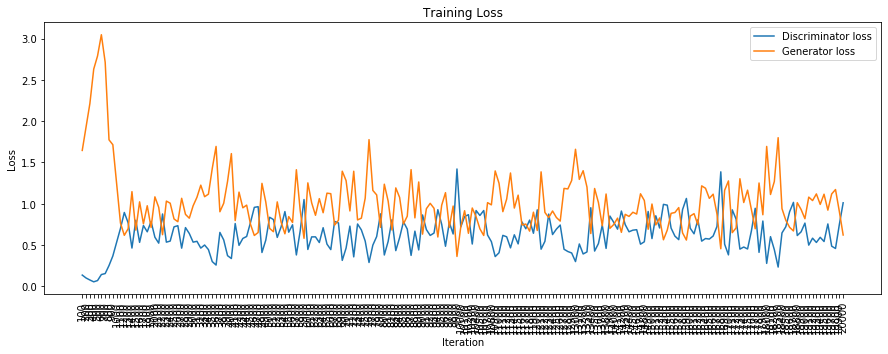

In [22]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

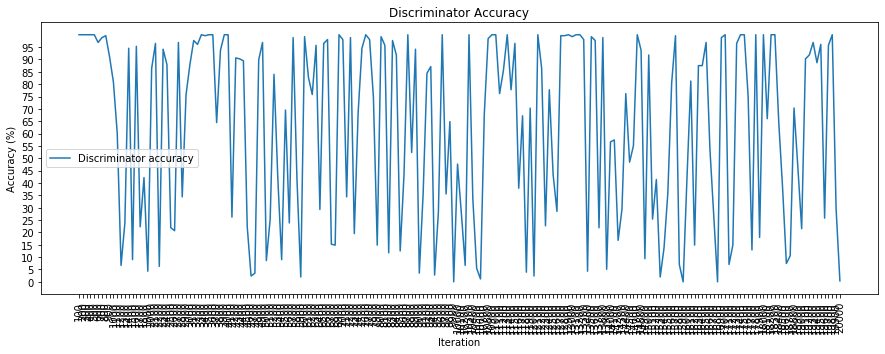

In [23]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()